### Cours optimisation continue, Antonin Chambolle : first order descent algorithms (forward-backward, FISTA)

## Example: a denoising problem

Ce programme vise à tester les méthodes forward-backward et forward-backward accéléré sur un problème simple de traitement d'image, le filtrage non-linéaire. Il s'agit, étant donné une image bruitée $g_{i,j}$, $i=1\dots M,
j=1\dots N$, de calculer:
$$ \min_{u} \sum_{i,j} \lambda \|(Du)_{i,j}\| + \frac{1}{2}\sum_{i,j} |u_{i,j}-g_{i,j}|^2. $$
Ici $D$ est un opérateur de "gradient" discret, donné par
$$
(Du)_{i,j} = \begin{pmatrix} u_{i+1,j}-u_{i,j} \\ u_{i,j+1}-u_{i,j} \end{pmatrix}.
$$
(Lorsque $i+1$ ou $j+1$ tombe en dehors du domaine on remplace la différence correspondant par $0$.

Par dualité, le problème s'écrit (voir le cours) :
$$
\min_u \max_{\|p_{i,j}\|\le\lambda} \sum_{i,j} p_{i,j}\cdot (Du)_{i,j} + \frac{1}{2}|u_{i,j}- g_{i,j}|^2 
=
 \min_u \max_{\|p_{i,j}\|\le\lambda} \sum_{i,j} (D'p)_{i,j} \,u_{i,j} + \frac{1}{2}|u_{i,j}- g_{i,j}|^2 
$$
où $D'$ est l'adjoint de $D$. 
En échangeant min et max, on obtient le problème dual:
$$
\max_{\|p_{i,j}\|\le \lambda} \min_u \sum_{i,j} (D'p)_{i,j} \,u_{i,j} + |u_{i,j}- g_{i,j}|^2 
= \max_{\|p_{i,j}\|\le \lambda} \sum_{i,j} (D'p)_{i,j} \,g_{i,j} - \frac{1}{2} |(D'p)_{i,j}|^2 
$$
Le min sur $u$ est obtenu pour $u_{i,j} = g_{i,j} - (D'p)_{i,j}$, c'est ainsi qu'on peut retrouver
la solution $u$ du problème primal à partir d'une solution $p$ du problème dual.

On est donc amené à résoudre le problème
$$
\min_{p} F(p) + G(p)
$$
avec
$$
F(p) = \sum_{i,j} \frac{1}{2} |(D'p)_{i,j}|^2  - (D'p)_{i,j} \,g_{i,j}
$$
et
$$
G(p) = \begin{cases} 0  &\mbox{ si } \|p_{i,j}\|\le\lambda \ \forall i,j \\ +\infty &\mbox{ sinon.} \end{cases}
$$

La fonction $F$ est différentiable, de gradient $\nabla F(p) = D(D'p-g)$. Le "prox" de la fonction $G$ est facile à calculer puisqu'il s'agit juste d'une projection, pour chaque $(i,j)$, du vecteur $p_{i,j}$ de dimension $2$
sur le disque de rayon $\lambda$. On admettra que $\|D^2 F\| = \|D D'\| = \|D\|^2 \le 8$.


Dans un premier temps on charge les packages utiles (numpy, skimage) et quelques fonctions.

En pratique pour utiliser aussi la version fortement convexe nous allons remplacer $G$ par $G_\varepsilon$,
pour $\varepsilon>0$ petit:
$$
G(p) = \sum_{i,j}
\begin{cases} \frac{\varepsilon}{2}\|p_{i,j}\|^2  &\mbox{ si } \|p_{i,j}\|\le\lambda \\ +\infty &\mbox{ sinon} \end{cases}
$$
qui est $\varepsilon$-convexe. Quel est le "prox" de $G$ ? Quel est le problème primal correspondant ?

In [15]:
"""
TP Optimisation Continue
Cours d'Antonin Chambolle

Created on Tue Dec 18 14:43:14 2018

@author: initial : Alexis THIBAULT / étudiant M2 Math. Modél. Paris 6
Corrigé et modifié : oct-novembre 2020 A. Chambolle
"""

# importation de packages
import numpy as np
import scipy.sparse as ssp
#from scipy import ndimage
import matplotlib.pyplot as plt  # pour figure, plots
from numpy import reshape as rs
from numpy.random import randn
from skimage import io
from skimage import img_as_float

On va charger une image avec la fonction io.imread de skimage, extraire sa taille $M\times N$ avec "shape".

In [16]:
u = io.imread('einstein.png',as_gray=True)
# u = np.array(u,dtype='float') # conversion en array numpy
u = img_as_float(u) # convertit l'image en float avec valeurs entre 0 et 1
#plt.imshow(u,'gray')

M,N = u.shape
#M,N = 3,5
print("taille de l'image :",M,N)
MN = M*N


taille de l'image : 600 800


On crée alors la matrice de l'opérateur "D".
C'est une matrice $(MN+ MN)\times MN$, en effet elle prend en entrée une image $M\times N$ transformée
en un vecteur de $MN$ lignes, et elle doit ressortir deux composantes (horizontale et verticale) pour
chaque pixel. A priori cette matrice est énorme, mais grâce au package "sparse" on peut la coder avec un espace mémoire d'ordre $O(MN)$.

Pour l'assembler, on crée d'abord un vecteur d'indices $M\times N$ contenant en $(i,j)$ le rang $i\times N+j$
du pixel $(i,j)$ dans la représentation colonne de l'image (tableau d'indices I).

Ensuite, on assemble une image "east" qui contient en $(i,j)$ le rang du pixel situé immédiatement à droite (saut pour $j=N$, où on met le rang du pixel courant. De façon similaire on assemble une image "north".

Ensuite, on réarrange ces vecteurs en vecteurs colonne avec la commande numpy "reshape".

Enfin, "D1", la matrice correspondant aux dérivées horizontales, est la matrice qui en $(iN+j,kN+l)$ contient $0$ si $(k,l)$ n'est pas $(i,j)$ ou $(i,j+1)$, et sinon, $1$ si $l=j+1$, $-1$ si $l=j$. 
La commande csr_matrix du package "sparse" prend en premier argument:
 "( valeurs, (lignes, colonnes) )" et assemble une matrice (de taille la plus petite possible, ou bien
 spécifiée ici par l'option "shape = (l,c)") où on trouve la $n^\mbox{ème}$ valeur du premier tableau à 
 l'emplacement spécifié par les $n$èmes valeurs des tableaux (lignes,colonnes).
 
 "D2" correspond aux dérivées verticales. "D" est la matrice $\left[ \begin{matrix} \mbox{D1} \\\mbox{D2} \end{matrix} \right]$.

In [17]:
# et I(m,n) est l'indice du pixel (m,n)
I = rs(np.arange(MN),(M,N))
east = rs(np.hstack((I[:,1:], I[:,-1:])),MN) # numpy compte à partir de 0, -1 correspond ici en fait 
                                            # à la dernière colonne de la matrice I, qu'on répète
north = rs(np.vstack((I[1:,:], I[-1:,:])),MN)
I = rs(I,MN)
# Dérivée horizontale
D1 = ssp.csr_matrix((np.ones(MN),(I, east)),shape=(MN,MN)) - ssp.eye(MN)
# Dérivée verticale
D2 = ssp.csr_matrix((np.ones(MN),(I,north)),shape=(MN,MN)) - ssp.eye(MN)
D = ssp.vstack((D1, D2))

Programme principal debruite(g,lbda,version,epsilon)

- g est l'image

- lbda est le paramètre de régularisation $\lambda$

- version = 1 : forward-backward standard ; version = 2 : FISTA ; version = 3 Nesterov fortement convexe
(ou non, si $\varepsilon=0$)

- epsilon pour la version 3

In [24]:
# Résolution du problème dual

def debruiter(g,lbda,version=2,epsilon=0.0):    
    if version==2:
        print("Calcul de la version accélérée...")
    elif version==1:
        print("Calcul de la version non accélérée...")
    elif version==3:
        print("Calcul de la version FISTA fortement convexe...")
    
    
    # On transforme l'image g en colonne:inéarise tout
    g = np.reshape(g,MN)

    D_ = D.transpose() # la matrice D'
    L = 8 # une borne sur la constante de Lipschitz de grad(F), ||DD'||
    tau = 1/L
    
    Q = tau*epsilon/(1+tau*epsilon) # pour la version Nesterov accélérée
    p = np.zeros(2*MN) 
    #D_p = D_.dot(p) 
    p_prev = p # pour les versions accélérées on doit connaitre le "p" courant et celui de l'itération précédente
    
    # pour la version accélérée type Nesterov / FISTA
    t = 1
    t_ = t
    
    gap = 1e6
    gaps = []
    
    k = 0
    # beta is the overrelaxation paramter:
    # one applies the descent algorithm to q=p^k + beta*(p^k-p^{k-1})
    while gap > 1 and k <= 400:
        if version==1:
            # Descente de gradient sur le dual
            beta = 0 # donc p -= tau * D.dot(D_p - g)
        elif version == 2:
            # Descente acceleree
            beta = k/(k+3)
        elif version == 3:
            t_ = (1-Q*t**2+np.sqrt((1-Q*t**2)**2+4*t**2))*0.5
            beta = (t-1)/t_ * (1-(t_-1)*tau*epsilon)
            t = t_
        
        # iteration principale : descente sur F
        q = p + beta*(p-p_prev)
        p_prev = p
        p = q - tau*D.dot(D_.dot(q) - g)
        
        # Prox de G : projection sur les vecteurs de norme <= lambda
        p = p/(1+epsilon*tau)
        norme_p = np.hypot(p[:MN],p[MN:]) / lbda
        diviseur = np.maximum(1,norme_p)
        p = p/np.concatenate((diviseur,diviseur)) # Division élément par élément
        
        # Calcul de la solution, et du gap
        D_p = D_.dot(p)
        v = g - D_p
        
        # Calcul du gap primal-dual :
        Dv = D.dot(v)
        normp = np.hypot(Dv[:MN],Dv[MN:])
        thresh = epsilon*lbda
        gap = lbda * np.sum(normp[normp>=thresh]-0.5*thresh)
        if epsilon > 0: 
            gap = gap + 0.5*np.sum(normp[normp<thresh]**2)/epsilon
        gap = gap + 0.5*epsilon*np.sum(p**2) - np.sum(D_p * v)
        # On construit un vecteur avec tous les gaps, pour observer la descente de l'algorithme
        gaps.append(gap) # gaps = [ gaps gap ];
        k+=1
        
    return rs(v,(M,N)),gaps

On ajoute un bruit à l'image u, et on définit le paramètre "$\lambda$":

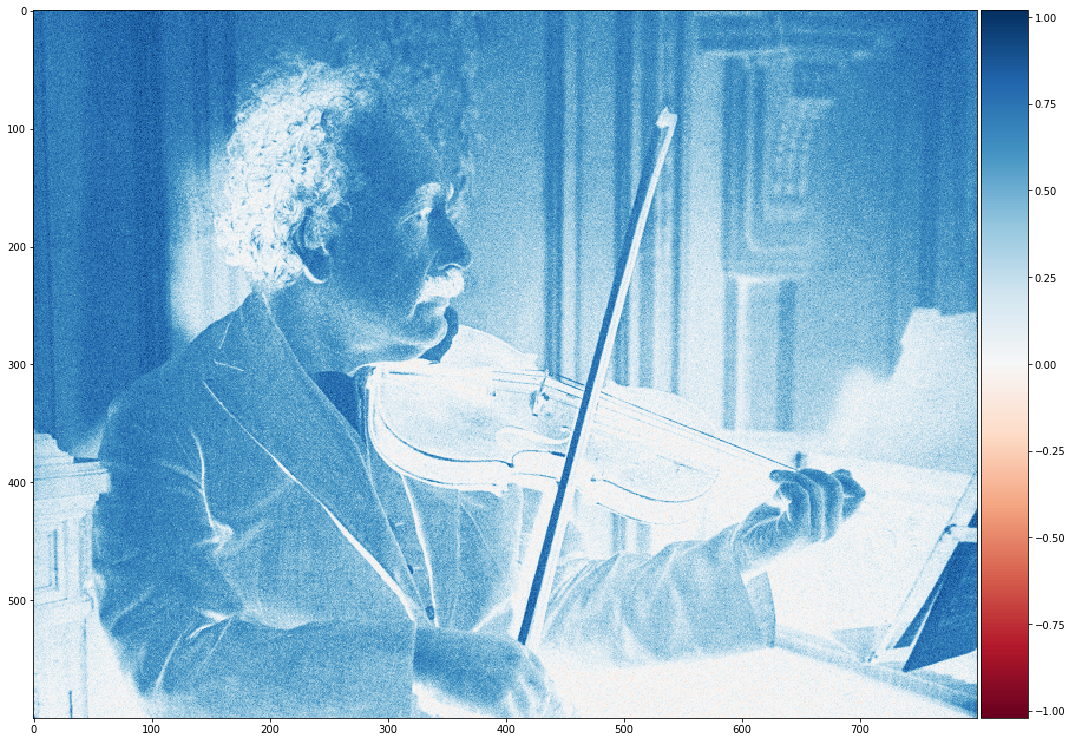

In [29]:
# Bruit
sigma = 0.05
g = u + sigma * randn(M,N)
#afficher(g)
io.imshow(g)

lbda = .O7 # lambda

In [30]:
# optimisation, versions 1,2,3

v1,gaps1 = debruiter(g,lbda,version=1)
v2,gaps2 = debruiter(g,lbda,version=2)
v3,gaps3 = debruiter(g,lbda,version=3,epsilon=.1)
print('done')

Calcul de la version non accélérée...
Calcul de la version accélérée...
Calcul de la version FISTA fortement convexe...
done


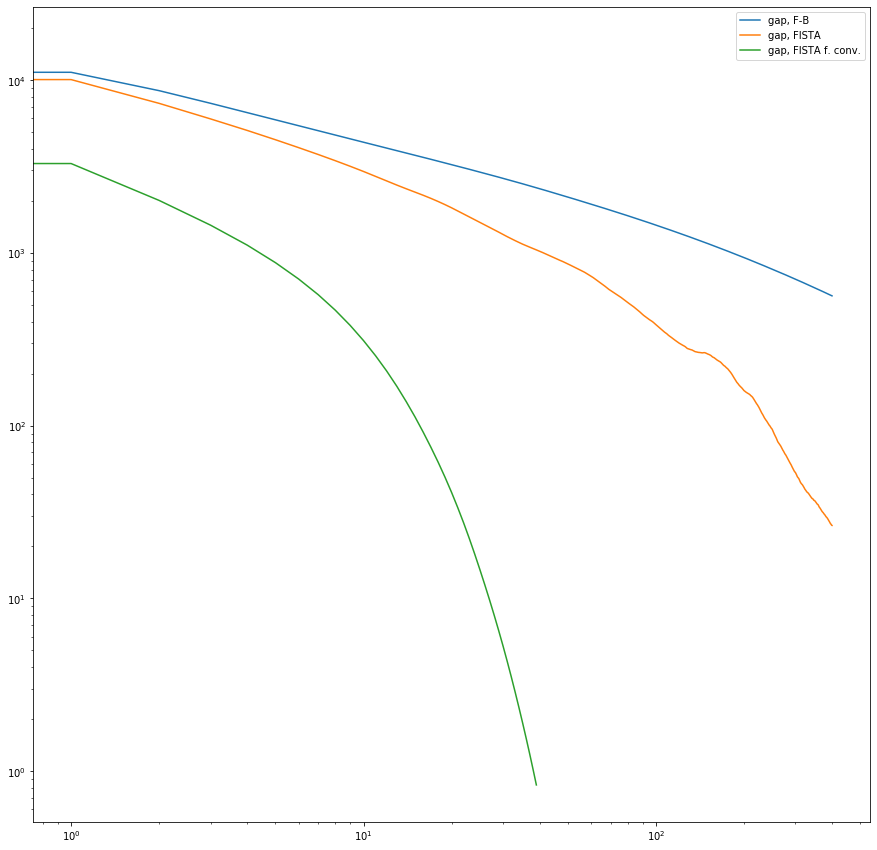

In [31]:
plt.loglog(gaps1,label="gap, F-B")
plt.loglog(gaps2,label="gap, FISTA")
plt.loglog(gaps3,label="gap, FISTA f. conv.")
plt.legend()

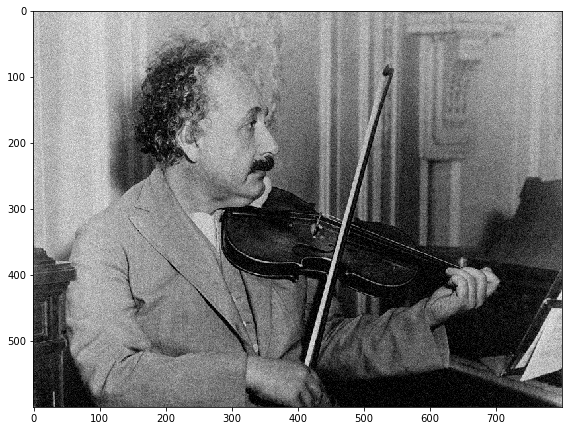

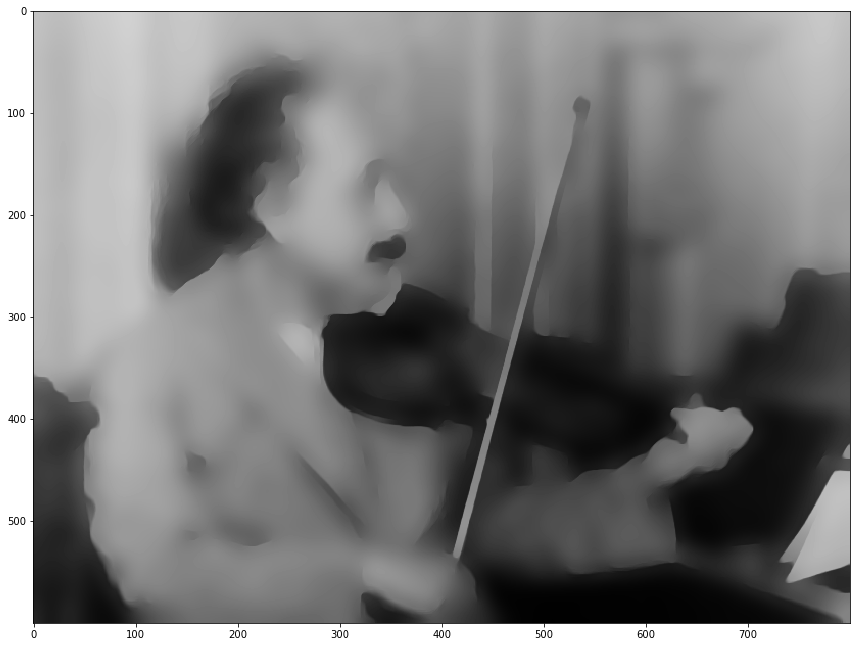

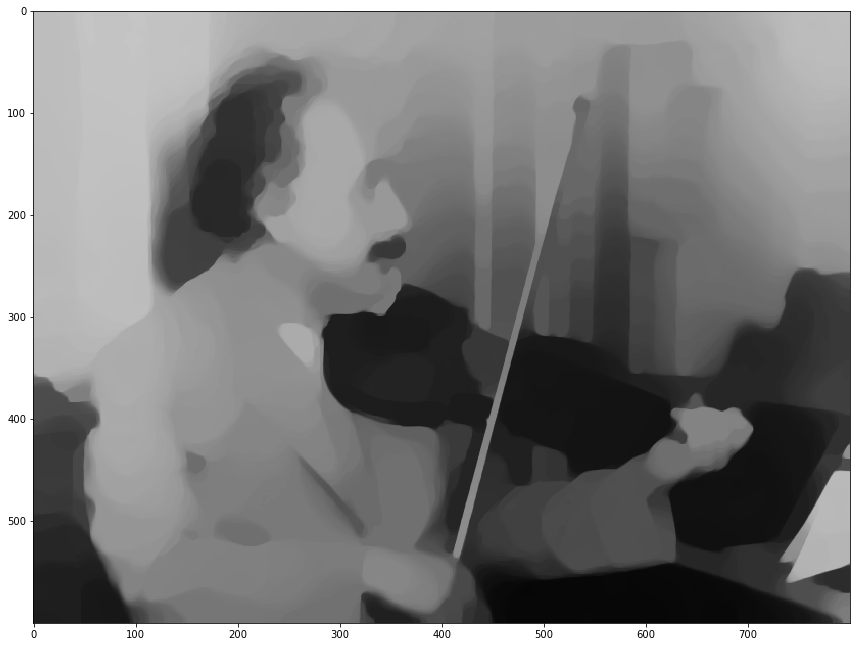

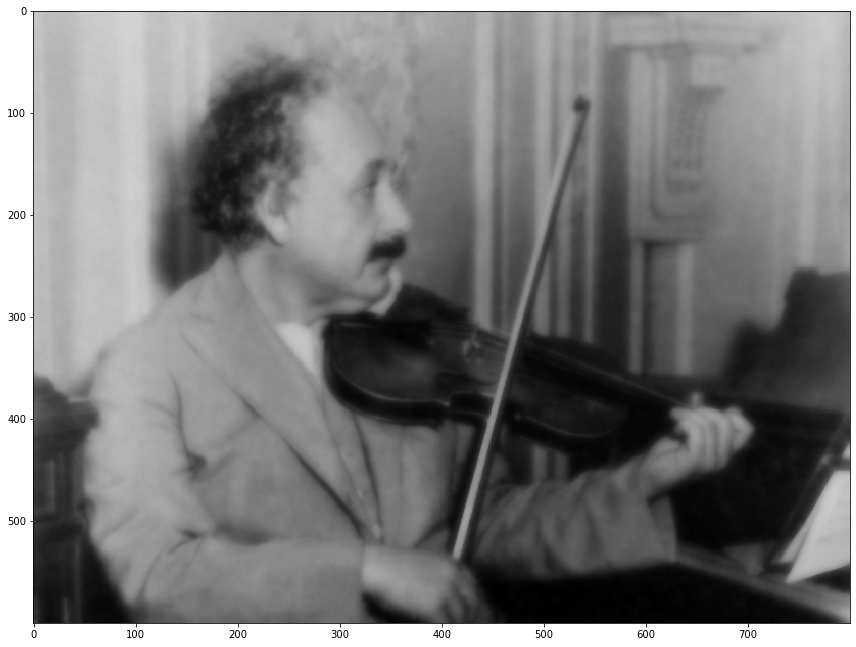

In [32]:
# afficher les images calculées
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure(figsize = (8,8))
io.imshow(np.minimum(np.maximum(g,0),1))
plt.figure(figsize = (12,12))
io.imshow(np.maximum(v1,0))
plt.figure(figsize = (12,12))
io.imshow(np.maximum(v2,0))
plt.figure(figsize = (12,12))
io.imshow(np.maximum(v3,0))


In [6]:
u.shape


(600, 800)

In [13]:
U = rs(u,MN)
print(U.shape)
P = D.dot(U)
print(P.shape)

(480000,)
(960000,)
